# An example of exact mapping from a ReLU network to a Spiking Neural Network

In this notebook we provide an example for a shallow fully-connected network and MNIST dataset.

#### Abstract
Deep spiking neural networks (SNNs) offer the promise of low-power artificial intelligence. However, training deep SNNs from scratch or converting deep artificial neural networks to SNNs without loss of performance has been a challenge. Here we propose an exact mapping from a network with Rectified Linear Units (ReLUs) to an SNN that fires exactly one spike per neuron. For our constructive proof, we assume that an arbitrary multi-layer ReLU network with or without convolutional layers, batch normalization and max pooling layers was trained to high performance on some training set. Furthermore, we assume that we have access to a representative example of input data used during training and to the exact parameters (weights and biases) of the trained ReLU network. The mapping from deep ReLU networks to SNNs causes zero percent drop in accuracy on CIFAR10, CIFAR100 and the ImageNet-like data sets Places365 and PASS. More generally our work shows that an arbitrary deep ReLU network can be replaced by an energy-efficient single-spike neural network without any loss of performance.

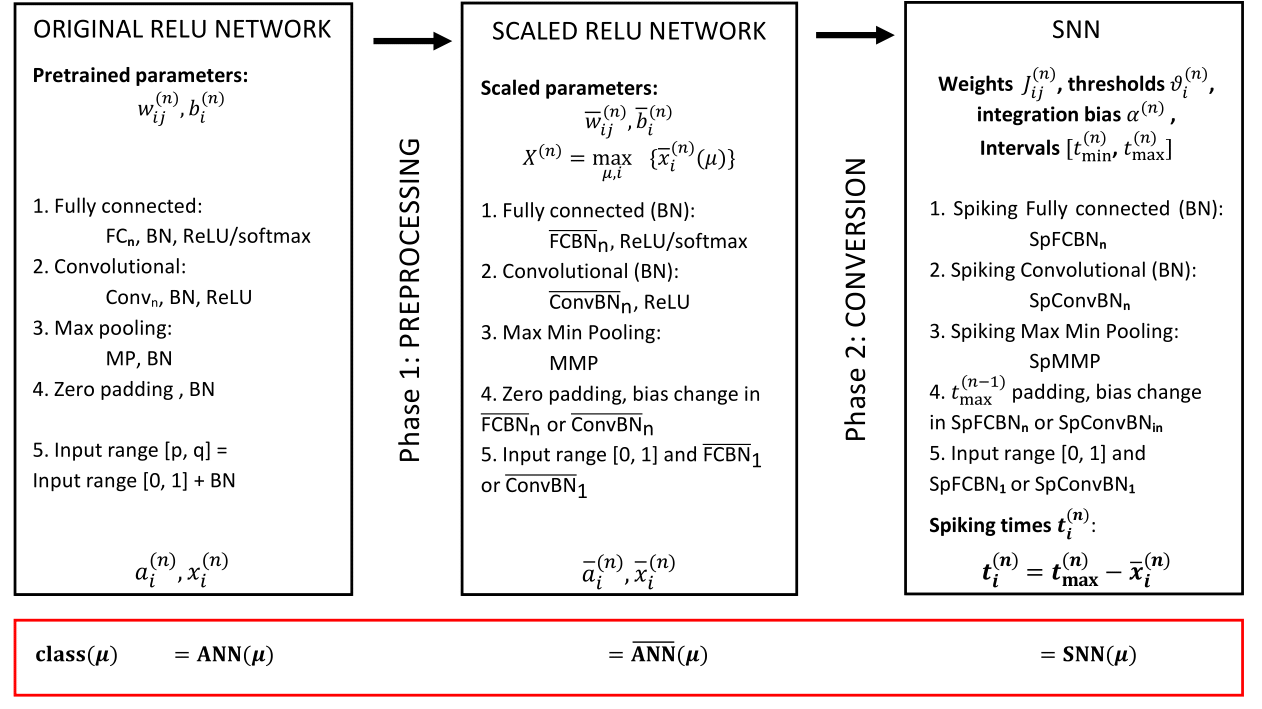

In [1]:
import sys
sys.path.insert(0, "./src")
import json
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import scipy
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, ActivityRegularization
from utils import *
from model import *
from Dataset import Dataset

2023-08-18 05:10:06.794927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Phase 1: Preprocess ReLU network 

In [2]:
# Create dataset and model; load pretrained weights; 
data_name='MNIST'
layers=2
CNN=False
logging_dir='./models/MNIST/FC/'
model_name='mnist_fc_relu_original'
data_ReLU = Dataset(
    data_name,
    logging_dir, 
    CNN,
    ReLU_preproc=True)
BN, BN_before_ReLU = False, False
model_ReLU=create_fc_model_ReLU()
print (model_ReLU.summary())
model_ReLU.load_weights(logging_dir + '/' + model_name + '.h5')

(60000, 784) (60000, 10) 



(10000, 784) (10000, 10) 



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 600)               471000    
_________________________________________________________________
activation (Activation)      (None, 600)               0         
_________________________________________________________________
activity_regularization (Act (None, 600)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
den

2023-08-18 05:10:13.887089: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-18 05:10:13.890113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-18 05:10:24.226960: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-18 05:10:24.227037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cccxl009): /proc/driver/nvidia/version does not exist
2023-08-18 05:10:24.230489: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
# Print model accuracy
print("Testing.")
test_acc = model_ReLU.evaluate(data_ReLU.x_test, data_ReLU.y_test)
print("Testing accuracy (ReLU original) is {}.".format(test_acc))

Testing.


2023-08-18 05:10:24.477707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-18 05:10:24.490731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3292040000 Hz


313/313 [==============================] - 1s 1ms/step - loss: 0.0774 - categorical_accuracy: 0.9840
Testing accuracy (ReLU original) is [0.06467155767258008, 0.9862].


In [4]:
# Create prediction labels and store them for computation of the agreement metric.
predictions_ReLU = model_ReLU.predict(data_ReLU.x_test)
predictions_ReLU = tf.argmax(predictions_ReLU, axis=1)
predictions_ReLU = (tf.keras.utils.to_categorical(predictions_ReLU, data_ReLU.num_of_classes))
pkl.dump(predictions_ReLU, open(logging_dir + '/' + model_name + '_labels.pkl', 'wb'))  
predictions_ReLU

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
# Fuse (imaginary) BN layers etc.
data_ReLU.x_test = (data_ReLU.x_test - data_ReLU.p)/(data_ReLU.q-data_ReLU.p)
data_ReLU.x_train = (data_ReLU.x_train - data_ReLU.p)/(data_ReLU.q-data_ReLU.p)
model_ReLU = fuse_bn(model_ReLU, BN, BN_before_ReLU, p=data_ReLU.p, q=data_ReLU.q)
print (model_ReLU.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               471000    
_________________________________________________________________
activation (Activation)      (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 477,010
Trainable params: 477,010
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# Scale convolutional and fully-connected layers and store X_n.
c, layer_num, X_n= 0, 0, [] 
non_zero_activations = 0
for k, layer in enumerate(model_ReLU.layers):
    if 'flatten' in layer.name:
        c = tf.tile(tf.squeeze(c), [layer.output_shape[-1]//layer.input_shape[-1]])
        c = tf.expand_dims(c, axis=0)
    if 'conv' in layer.name or 'dense' in layer.name: 
        #logging.info (layer.name, '\n\n\n')
        # Scale weights of the current layer.
        c, layer_num = set_params_ReLU(layer, c, layer_num, layers)
        if k!=len(model_ReLU.layers)-2:
            # Calculate X_n of the current layer.
            extractor = tf.keras.Model(inputs=model_ReLU.inputs, outputs=tf.reduce_max(tf.nn.relu(layer.output)))
            output = extractor.predict(data_ReLU.x_train)
            X_n.append(np.max(output))
print('X_n:', X_n)
pkl.dump(X_n, open(logging_dir + '/' + model_name.replace('original', 'scaled_X_n.pkl'), 'wb'))
print(model_ReLU.summary())

# Store weights of the scaled model
model_ReLU.save_weights(logging_dir + '/' + model_name.replace('original', 'scaled.h5'))

X_n: [8.972876392074289]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               471000    
_________________________________________________________________
activation (Activation)      (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 477,010
Trainable params: 477,010
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# Print model accuracy
print("Testing.")
test_acc = model_ReLU.evaluate(data_ReLU.x_test, data_ReLU.y_test)
print("Testing accuracy (scaled ReLU) is {}.".format(test_acc))

Testing.
313/313 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9840
Testing accuracy (scaled ReLU) is [0.06467155767258008, 0.9862].


### Phase 2: Convert the scaled ReLU network to an SNN

In [8]:
# Create data object
model_name='mnist_fc_relu_scaled'
data_SNN = Dataset(
    data_name,
    logging_dir,
    CNN,
    ReLU_preproc=False,
    model_name='mnist_fc_relu_scaled'
)

(60000, 784) (60000, 10) 



(10000, 784) (10000, 10) 





In [11]:
# Create spiking model. Load weights from the scaled ReLU network.
robustness_params={'noise':0, 'alpha_noise': 0, 'zeta':0.5}
model_SNN = create_fc_model_SNN(logging_dir, model_name, robustness_params=robustness_params)
model_SNN.load_weights(logging_dir + '/' + model_name + '.h5', by_name=True) 
t_min, t_max= 0, 1  
# Set parameters of the SNN network.
for layer in model_SNN.layers:
    if 'dense' in layer.name: t_min, t_max = layer.set_params(t_min, t_max)   
print("Testing.")
val_acc, agreement=[], []
predictions_SNN = model_SNN.predict(data_SNN.x_test, verbose=1)
predictions_SNN=np.argmax(predictions_SNN, axis=1)
test_acc =np.mean(predictions_SNN==np.argmax(data_SNN.y_test, axis=1))
print("Testing accuracy (SNN model) is {}.".format(test_acc))
agreement = np.mean(predictions_SNN==np.argmax(predictions_ReLU, axis=1))
print("Agreement (SNN-ReLU) is {}.".format(agreement))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (SpikingDense)         (None, 600)               471000    
_________________________________________________________________
dense_1 (SpikingDense)       (None, 10)                6010      
Total params: 477,010
Trainable params: 477,010
Non-trainable params: 0
_________________________________________________________________
None
Testing.
313/313 [==============================] - 48s 154ms/step
Testing accuracy (SNN model) is 0.9862.
Agreement (SNN-ReLU) is 1.0.
